## Initialization

In [2]:
#%load_ext autoreload
#%autoreload 2

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import numpy as np
import math
import ipywidgets as widgets

from plot_helpers import *

import warnings
warnings.filterwarnings('ignore')
# %matplotlib qt5
%matplotlib inline
# %matplotlib widget

# pd.set_option('display.max_rows', 1000)

############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

# plt.style.use('ggplot')
# plt.style.use(['ggplot'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]

def xm(x):
    return np.array([x,   1])
def ym(y):
    return np.array([1,   y])

default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'

############### Experiment selection ###################

EXP_list = [exp_folder.split('/')[-1] for exp_folder in sorted(glob.glob('%s/*' % datadir))]
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir, exp)))] for exp in EXP_list}
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir, exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Exp:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    description='Exp:',
    disabled=False,
)

CFG_drop    = widgets.Dropdown(description='Cfg:',options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:',options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)

def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
        
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_df(lf, select = True):
    global df_exp
    global logfile
    global loaded
    
    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(3,2)
        grid[0,0] = EXP_drop
        grid[1,0] = CFG_drop
        grid[2,0] = REP_drop
        grid[1,1] = LOAD_button
        grid[2,1] = CONF_button
        display(grid)
    
    if loaded != (EXP_drop.value, logfile):
        LOAD_button.click()
        on_change({'type':'change', 'name':'value'})
    df = df_exp
    
    if CFG_drop.value != 'all':
        df = df.query("CFG in @CFG_drop.value")

    if REP_drop.value != 'all':
        df = df.query("REP in @REP_drop.value")
    return df

# Automatically default the dataset to most recently changed
all_subdirs = ['data/'+d for d in os.listdir('data/')]
latest_subdir = max(all_subdirs, key=os.path.getmtime)
EXP_drop.value = latest_subdir.split('/')[-1]
print(latest_subdir)


data/12rob


In [58]:
%%html

<style>
    .jp-OutputArea-child:has(> .jp-RenderedImage) {
        display: inline-block;
    }
</style>

## Time elapsed between blocks (histogram)

SelectMultiple(description='Exp:', index=(0,), options=('test1',), value=('test1',))

Experiment datasets: test1


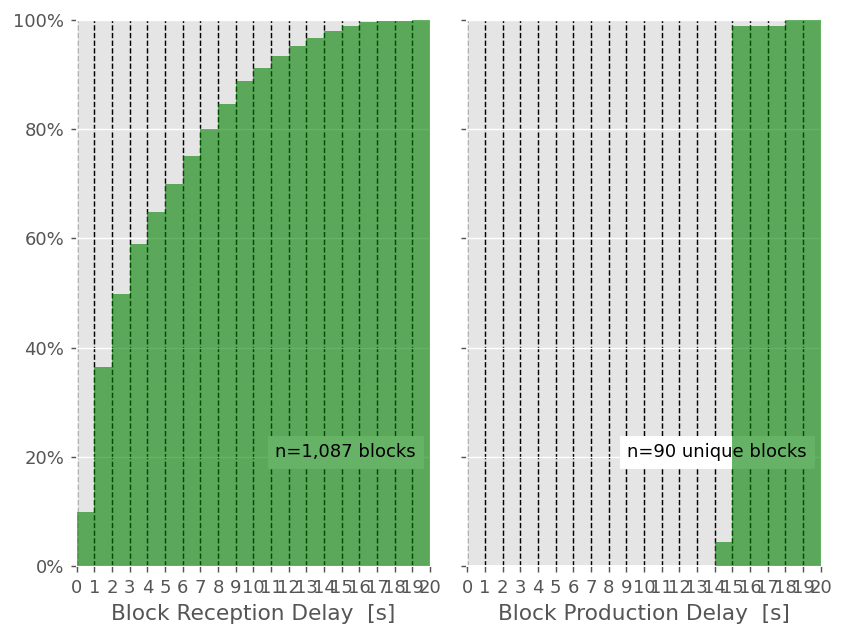

In [2]:
display(EXP_multiple)
EXP = EXP_multiple.value
print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
df = create_df(EXP, 'block')
# display(df)
# df = df.get_param(df,'generic_params','block_period')
XMAX = 20

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create figure
fig, ax = plt.subplots(1,2, sharey=True, figsize=double)

# Create plot
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder= 3)
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder=3)
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[1].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
fig.tight_layout()
# plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

Dropdown(description='Exp:', options=('test1',), value='test1')

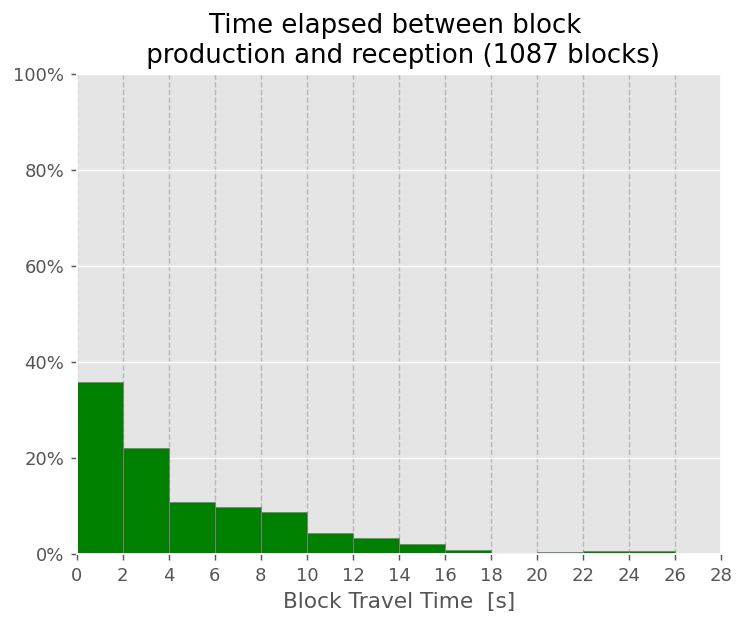

In [3]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')
# df = df.get_param(df,'generic_params','block_period')

# Process the data  
bins = range(0, 30, 2)
# XX = df.groupby('HASH')['TELAPSED'].agg('max')
XX = df['TELAPSED']

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
plt.savefig("plots/"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between consecutive blocks

Dropdown(description='Exp:', options=('test1',), value='test1')

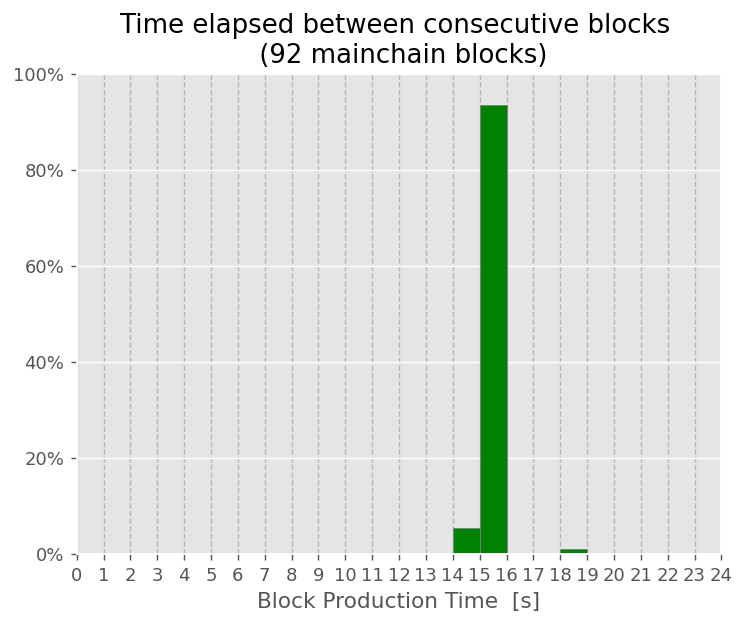

In [11]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df(EXP, 'block')

# Process the dataframe  
# df = df.get_param(df,'generic_params','block_period')
bins = range(0, 25, 1)

df = df.drop_duplicates('HASH')
df = trim_chain(df, 8).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
plt.savefig("plots/"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Check how many blocks were produced

In [ ]:
# df = load_df('block')

# # Process the dataframe  
# df = df.get_param(df,'generic','block_period')
# df = df.drop_duplicates('HASH')
# YY = 'BLOCK'

# # df['main_leaf'] = df.groupby(['EXP', 'CFG', 'REP'], as_index=False)['TDIFF'].transform('idxmax').reset_index()

# dg = df.groupby(['EXP', 'CFG', 'REP'], as_index=False)

# for name, group in dg:
    
#     group = group.reset_index()
    
#     main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]
    
#     # Iterate from main_leaf to genesis -> mainchain
#     df_mainchain = get_mainchain_df(group, main_leaf)          
# #     print(name, len(df_mainchain))


# get_mainchain_df(df, main_leaf)
# df.groupby(['EXP', 'CFG', 'REP'], as_index=False).apply(lambda x: get_mainchain_df(x, x['TDIFF']))

# display(df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({YY:'max'}))
# display(main_df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({YY:'max'}))




## (extra timeplot) memory cost vs time

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('both_tes…

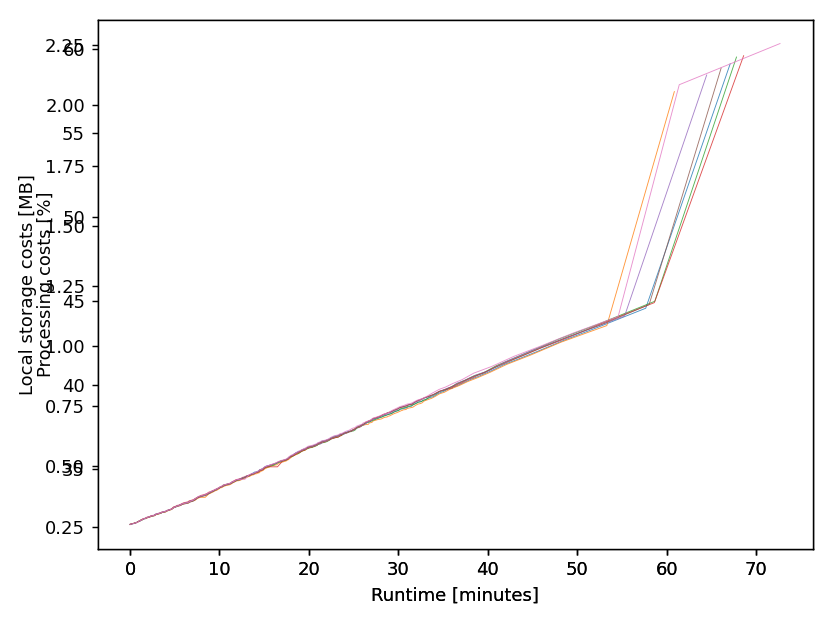

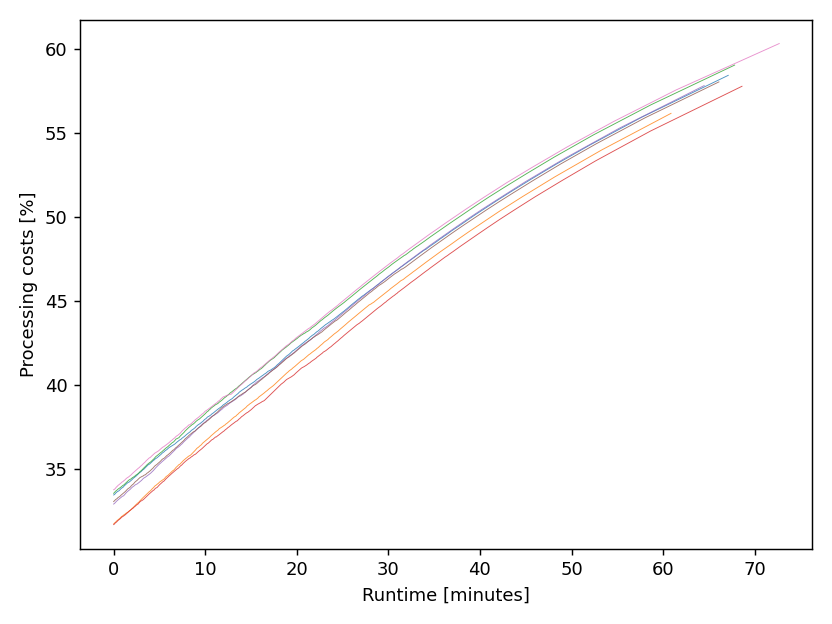

SyntaxError: invalid syntax (<unknown>, line 1)

In [19]:
# Generate the dataframe
df = load_df('extra')

df['TIME_M'] = df['TIME'].round().astype(int) /60
df['MB'] = df['CHAINDATASIZE']/1e6
# df = df.query('REP == "001"')
# display(df)
# Process the dataframe  
# df = df.groupby(['Robots']).apply(lambda x: LinearRegression(x, 'TIME', 'MB'))

# display(df[['Robots','MB']])
# Create plot

# display(df)
# df = df[['Robots','TIME_M','MB']]
# display(df.groupby(['Robots', 'TIME_M'], as_index=False).mean().set_index('TIME_M')['MB'])

# df.groupby(['REP'], as_index=False).mean().set_index('TIME)['MB'].plot(ax=ax)

# df.groupby('Robots').boxplot(column='MB', by='TIME_MR', figsize=double)
# sns.boxplot(x=df['TIME_MR'], y=df['MB'], hue=df['Robots'], showfliers = False)

# display(df)
# s = df.pivot('TIME_M', 'ID', 'MB').mean(axis=1).resample('0.15S').mean()

# display(df)
# df['MB_mov_avg'] = df.set_index(['TIME_M']).groupby('REP')['MB'].transform(lambda x: x.rolling(10, 1).mean())
# df['MB_mov_avg'] = df.set_index(['TIME']).groupby('REP').rolling(10)['CHAINDATASIZE'].mean().reset_index(drop=True)
# display(df)
# s.plot(ax = ax, figsize = double)
# display(df)
ax = plt.axes()
df.set_index(['TIME_M']).groupby(['CFG','REP','ID'])['MB'].plot(ax = ax, label='_nolegend_', linewidth=0.5, alpha = 0.8, zorder=0)

# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Local storage costs [MB]')
# ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()

i=0
color_map = plt.get_cmap('tab10')
fig, ax = plt.subplots()
for rep_value, rep_data in df.set_index(['TIME_M']).groupby(['CFG', 'REP', 'ID'])['%CPU']:
    rep_data.plot(ax=ax, label=rep_value, color=color_map(i), linewidth=0.5, alpha=0.8, zorder=0)
    i+=1
# Edit plot
# xmax = math.ceil(df['TIME'].max()/60)
# xticks = range(0,xmax,1)
# ax.set_xlim(xmin=0,xmax = xmax)
# ax.set_xticks(xticks) 
ax.set_xlabel('Runtime [minutes]')
ax.set_ylabel('Processing costs [%]')
# ax.legend(loc='best', bbox_to_anchor=(1, 0.5), title = 'Number of\nrobots')
plt.gcf().tight_layout()

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/local_memory.png", bbox_inches='tight', dpi=600)
# plt.savefig("plots/multi/local_memory.png", bbox_inches='tight', dpi=600)
plt.show()
df=df.query('REP==001')

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'extra')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df['TIME_M'] = df['TIME']/60
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'MB'
yl = 'Local storage costs [MB]'
fs = hlwidth

# Process the data
df = df.groupby(['EXP','CFG', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
print(df.query('COEFS < 0.4'))
# df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
# ax = plt.axes()
fig,ax = plt.subplots(1,1,figsize=fs) 

bp = df.boxplot(column='COEFS', by = XX, figsize=fs, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, figsize=flhh, ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
display(EXP_drop)
EXP = EXP_drop.value

# Generate the dataframe
df = create_df2(EXP, 'loop_function')
df = get_param_df2(df, 'generic_params', 'num_robots', alias = 'Robots')
df = df.query('Robots <= 25')

# Plot options
XX = 'Robots'
YY = 'VALUE'
yl = 'Reward'
fs = hlwidth

# Process the data
# df = df.groupby(['EXP', 'REP']).apply(lambda x: LinearRegression0(x, 'TIME_M', 'MB'))
df = df.groupby(['Robots', 'REP'], as_index=False).agg({YY:'max'})

# Create plot
fig,ax = plt.subplots(1,1,figsize=fs) 
# bp = df.boxplot(column='COEFS', by = XX, ax=ax)
# bp = df.boxplot(column=[YY], by = XX, ax=ax)
bp = sns.violinplot(df[XX], df[YY])
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel("Number of %s" % ax.get_xlabel())
ax.set_ylabel(yl)
ax.set_title('')   

# Save plot
plt.gcf().tight_layout()
plt.savefig("plots/experiment_"+EXP+"/performance_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## (sc boxplot) Balance vs robot

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('12rob', …

ParserError: Error tokenizing data. C error: Expected 7 fields in line 7, saw 8


ValueError: not enough values to unpack (expected 2, got 0)

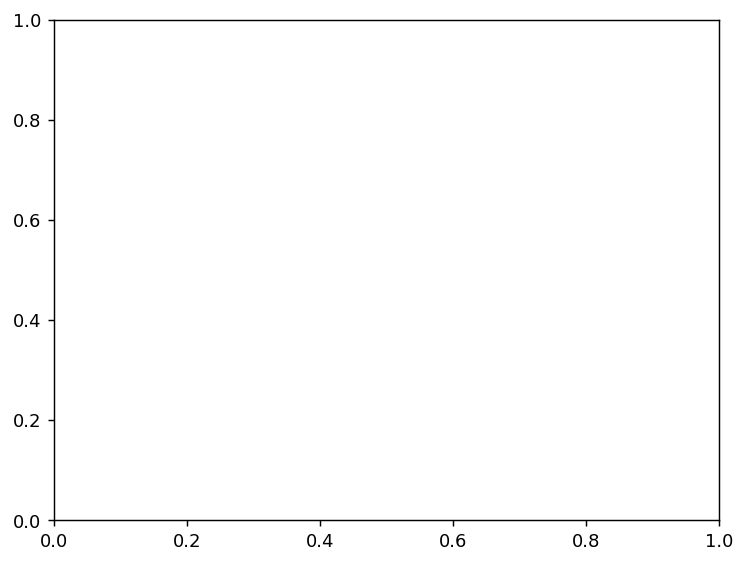

In [9]:
%matplotlib inline
# Generate the dataframe
df = load_df('sc')

# Plot options
XX = 'ID'
YY = 'BALANCE'
yl = 'Balance'
xl = 'Robot #'
fs = double

# Corrections to dataframe
df['ID'] = df['ID'].astype(int)

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Group by 'REP' and 'ID', and get the last value of 'YY'
grouped = df.groupby(['REP', 'ID'])[YY].agg('last').reset_index()

grouped.boxplot(column=YY, by='ID', ax=ax)

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 30)

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()



## (sc timeplot) Balance vs time 

GridspecLayout(children=(Dropdown(description='Exp:', index=2, layout=Layout(grid_area='widget001'), options=(…

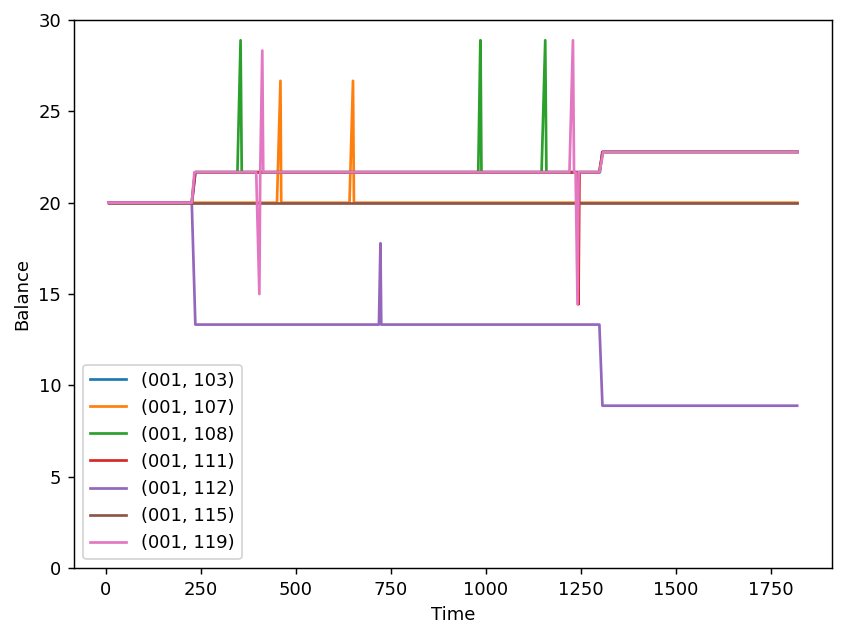

In [53]:
# Generate the dataframe
df = load_df('sc')

# Plot options
XX = 'TIME'
YY = 'WALLET'
yl = 'Balance'
xl = 'Time'
fs = double

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Group by 'REP' and 'ID', and get the last value of 'YY'
df.set_index('TIME').groupby(['REP', 'ID'])[YY].plot()

# Set the labels
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 30)
ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Clusters

GridspecLayout(children=(Dropdown(description='Exp:', index=2, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: sucess datafile: cluster


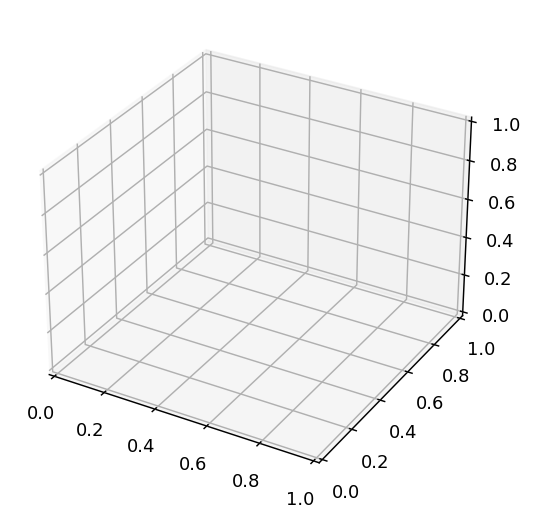

In [54]:
df = load_df('cluster')

df = df.drop_duplicates('position')

df['B'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[0], axis=1).div(100000)
df['G'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[1], axis=1).div(100000)
df['R'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[2], axis=1).div(100000)
df.to_csv('all_robot_clusters.csv', index=False)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.scatter(df['R'], df['G'], df['B'], color='black', alpha=1.0, edgecolors='none')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_zlim([0,255])

plt.show()

## Points and Clusters

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('12rob', …

Loaded || dataframe: 12rob datafile: cluster
Loaded || dataframe: 12rob datafile: color


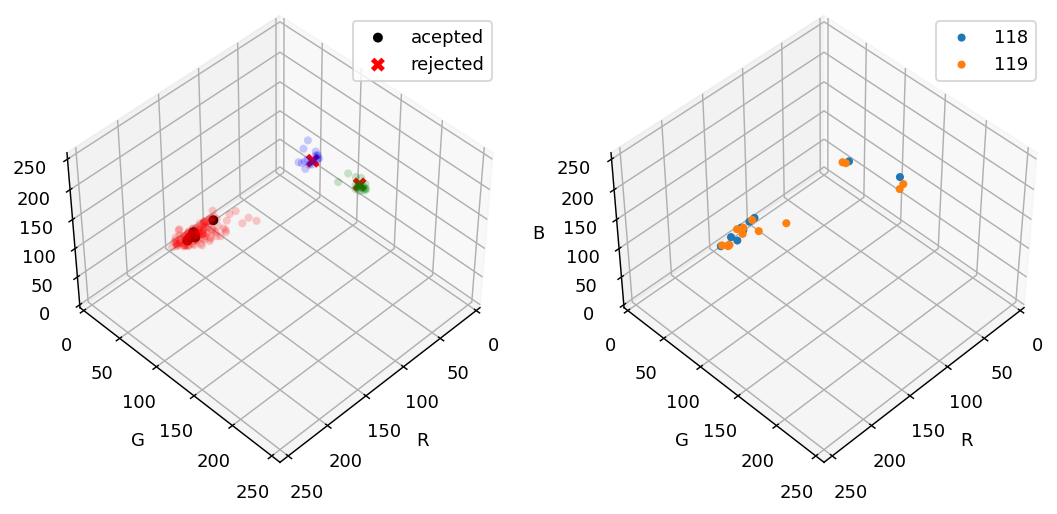

In [21]:
%matplotlib inline

# Create dataframe
df = load_df('color')

# Create a 3D plot
fig = plt.figure(figsize = 1.5*double)
ax = fig.add_subplot(131, projection='3d')
for name, group in df.groupby('NAME'):
    ax.scatter(group['R'], group['G'], group['B'], color=name, alpha=0.2, edgecolors='none')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_zlim([0,255])

df = load_df('cluster', select = False)
df = df.drop_duplicates('position')
df['B'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[0], axis=1).div(100000)
df['G'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[1], axis=1).div(100000)
df['R'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[2], axis=1).div(100000)

dfa = df.query('verified==1')
ax.scatter(dfa['R'], dfa['G'], dfa['B'], color='black', alpha=1.0, marker='o', s=30, edgecolors='none', label='acepted')

dfr = df.query('verified==2')
ax.scatter(dfr['R'], dfr['G'], dfr['B'], color='red', alpha=1.0, marker='X', s=60, edgecolors='none', label='rejected')
ax.legend()
ax.view_init(elev=45, azim=45)

df = load_df('color', select = False)
ax = fig.add_subplot(132, projection='3d')
# df_unique = df[['ID', 'isbyz']].drop_duplicates()
# print(df_unique)
for name, group in df.query('isbyz').groupby('ID'):
    ax.scatter(group['R'], group['G'], group['B'], alpha=1, edgecolors='none', label=name)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.legend()
ax.view_init(elev=45, azim=45)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_zlim([0,255])

ax = fig.add_subplot(133, projection='3d')

for name, group in df.query('FOOD').groupby('ID'):
    ax.scatter(group['R'], group['G'], group['B'], alpha=1, color='red', edgecolors='none', label=name)
for name, group in df.query('FOOD').groupby('ID'):
    ax.scatter(group['R'], group['G'], group['B'], alpha=1, edgecolors='none', label=name)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.legend()
ax.view_init(elev=45, azim=45)
ax.set_xlim([0,255])
ax.set_ylim([0,255])
ax.set_zlim([0,255])


plt.show()

In [ ]:


# for name, group in groups:
#     # plt.hist(group['B'], bins=20, color='red') 
#     # plt.hist(group['G'], bins=20, color='blue') 
#     # plt.hist(group['R'], bins=20, color='green') 
#     group['R'].plot.kde(color='red')
#     group['B'].plot.kde(color='blue')
#     group['G'].plot.kde(color='green')
#     plt.title(f"PDF Plot for Group {name}")
#     plt.xlabel('Value')
#     plt.ylabel('Probability Density')
#     plt.show()

# plt.show()

# df['H'] = df.apply(lambda row: bgr_to_hsv(row['B'], row['G'], row['R'])[0], axis=1)
# df['S'] = df.apply(lambda row: bgr_to_hsv(row['B'], row['G'], row['R'])[1], axis=1)
# df['V'] = df.apply(lambda row: bgr_to_hsv(row['B'], row['G'], row['R'])[2], axis=1)

# # Create a 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for name, group in color_groups:
#     ax.scatter(group['H'], group['S'], group['V'], color=name, alpha=1.0, edgecolors='none')
# ax.set_xlabel('H')
# ax.set_ylabel('S')
# ax.set_zlabel('V')
# # ax.view_init(elev=90, azim=90)

In [149]:
# # Create dataframe
df = load_df('color')
# # Group by 'NAME' column and compute the variance
# variance_df = df.groupby('NAME')[['B', 'G', 'R']].var()

# # Calculate the square root of the mean variance
# centroid_df = np.sqrt(variance_df[['B', 'G', 'R']].sum(axis=1) / 3)
# display(centroid_df)

# Define the number of values to sample
sample_size = 5

# Group by 'NAME' column and compute the variance
sampled_df = df.groupby('NAME')[['B', 'G', 'R']].apply(lambda x: x.sample(n=sample_size))

variance_df = sampled_df.groupby('NAME')[['B', 'G', 'R']].var()
# display(variance_df)
# Sample the values
# sampled_variances = variance_df.apply(lambda x: x.sample(n=sample_size, random_state=42))

# # Calculate the square root of the mean variance
centroid_df = np.sqrt(variance_df.sum(axis=1) / 3)

# # Print the resulting centroid DataFrame
display(centroid_df)

# Create dataframe
df = load_df('cluster', select = False)
df = df.drop_duplicates('position')
df['B'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[0], axis=1).div(100000)
df['G'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[1], axis=1).div(100000)
df['R'] = df.apply(lambda row: eval(row['position'].replace(',', ', '))[2], axis=1).div(100000)


# Group by 'NAME' column and compute the variance
variance_df = df.query('verified==1')[['B', 'G', 'R']].var()
# display(variance_df)
# Calculate the square root of the mean variance
centroid_df = np.sqrt(variance_df.sum())
display(centroid_df)

GridspecLayout(children=(Dropdown(description='Exp:', index=2, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: sucess datafile: color


NAME
blue     15.582225
green    10.476896
red      14.543801
dtype: float64

Loaded || dataframe: sucess datafile: cluster


18.055286343648312

## Blockchain Visualizer (graph)

In [7]:
# Select which experiment to plot the whole blockchain
df = load_df('block')
df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
df = df.query('BLOCK<=450')

# Process data
genesis = df['PHASH'].iloc[0]
main_leaf = df[df['TDIFF'] == df['TDIFF'].max()]['HASH'].iloc[0]

# Iterate from main_leaf to genesis -> mainchain
df_mainchain = get_mainchain_df(df, main_leaf)

# Block hashes not in the mainchain -> forks
df_forks = df.query("HASH not in @df_mainchain['HASH']")

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')


GridspecLayout(children=(Dropdown(description='Exp:', index=2, layout=Layout(grid_area='widget001'), options=(…

Loaded || dataframe: sucess datafile: block


In [8]:
TRIM_FORKS = 0

# fork_paths = [[y] for y in df_leafs['HASH']]
# df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)
# fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)
# nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)
# df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @df_mainchain['HASH']')

df_trimmed = trim_chain(df, TRIM_FORKS)
# display(df_trimmed)

bc = create_digraph(df)
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')


# # Do something cool? Idk, make all black for mini-plot
# df_trimmed.apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='black'), axis = 1)
# bc_trimmed.node(genesis, style='filled', fillcolor='black')

# # Do something cool? Idk, for example try to keep all forks at same level (slow!)
# df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
bc_trimmed.render('plots/blockchain', format='pdf', view=True)
bc_trimmed

Gtk-Message: 11:13:23.385: Failed to load module "canberra-gtk-module"
[TimeStamp]-----main-----begin
svn:  rb70e8df


##################################################
##############Foxit Reader Setup Log##############
################################################## 


[TimeStamp]-----CReader_AppEx::InitInstance()-----begin
[TimeStamp]-----CMainWindow::Init()-----begin
QObject::connect: No such slot CMainActions::Update_EditMenu()
QObject::connect:  (sender name:   'mainwindow')
QObject::connect: Use the SLOT or SIGNAL macro to connect CMainWindow::
xdg-mime return the value that is  "FoxitReader.desktop
"
QLayout: Attempting to add QLayout "" to CMainToolbar "", which already has a layout
QLayout: Attempting to add QLayout "" to CMainToolbar "", which already has a layout
QLayout: Attempting to add QLayout "" to CMainToolbar "", which already has a layout
